In [1]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from keplergl import KeplerGl
import matplotlib.pyplot as plt
from shapely.geometry import Point, shape
from math import atan2, cos, radians, sin, sqrt

/Users/hongde.liang/opt/anaconda3/envs/py36hd/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Setting up

In [2]:
pd.set_option('max_columns', None)
pd.set_option("max_rows", None)

In [606]:
df = pd.read_csv('Taxi_Trips_-_2021.csv')

In [607]:
useful_columns = [
    'Fare',  
    'Company',
    'Trip Miles', 
    'Trip Seconds', 
    'Trip Start Timestamp', 
    'Payment Type',
    'Pickup Centroid Latitude',
    'Pickup Centroid Longitude', 
    'Dropoff Centroid Latitude', 
    'Dropoff Centroid Longitude'
]
df = pd.read_csv('Taxi_Trips_-_2021.csv', usecols=useful_columns)
df = df.dropna()
df = df.drop_duplicates()

In [5]:
DISTANCE_DECIMAL = 3
def flying_distance(lat1, lon1, lat2, lon2):
    """calculate the spherical distance between two locations
    :return: scalar of distance in meters
    """
    
    lat1, lon1, lat2, lon2 = (radians(float(val)) for val in [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    val1 = (sin(dlat / 2)) ** 2 + cos(lat1) * cos(lat2) * (sin(dlon / 2)) ** 2
    val2 = 2 * atan2(sqrt(val1), sqrt(1 - val1))
    radius = 6371.0
    distance = round(radius * val2 * 1000, DISTANCE_DECIMAL)
    return distance

In [6]:
# Chicago Census polygon data obtained from 
# https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2010/5jrd-6zik
# There are a total of 801 census tracks in Chigago
# name10: the name of the census tracks
# commarea: area of the census tracks
# geometry: census track boundary in the form of polygons

census = gpd.read_file('Chicago_Census_Tracts.geojson')
census_tracts = census[['name10', 'commarea', 'geometry']]
gpdrtree_index = census_tracts['geometry'].sindex
def reverse_geocode_census(lat, lon):
    """use geopandas rtree method for reverse geocoding
    return the census tract name based on lat and lon
    """
    if lat and lon:
        lat, lon = [float(item) for item in [lat, lon]]
        location = Point(lon, lat)
        targets_index = gpdrtree_index.query(location)
        for index in targets_index: 
            if census_tracts.iloc[index, 2].contains(location):
                census_tract = census_tracts.iloc[index, 0].lower()
                return census_tract
    return None

In [7]:
def unit_fare(fare, miles):
    """calculate the average fare per mile
    return Null if miles = 0"""
    return fare/miles if miles else None

# Visual

In [608]:
df_sample = df.sample(3000)

In [609]:
len(df_sample)

3000

In [610]:
map_chicago_visual =KeplerGl(height = 800)
map_chicago_visual.add_data(data = df_sample, name = 'trip sample 3000')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [612]:
map_chicago_visual.save_to_html(file_name='map_chicago_visual.html')

Map saved to map_chicago_visual.html!


In [611]:
map_chicago_visual

KeplerGl(data={'trip sample 3000': {'index': [973288, 1018284, 1119589, 394565, 264851, 805893, 637717, 335191…

# Process data

In [82]:
df['Timestamp'] = pd.to_datetime(df['Trip Start Timestamp'])
df['is_weekday'] =[bool(d.weekday() < 5) for d in df['Timestamp']]
df['hour'] = [d.hour for d in df['Timestamp']]
df['pick_up_census'] = df.apply(
    lambda x: reverse_geocode_census(x['Pickup Centroid Latitude'], x['Pickup Centroid Longitude']), 
    axis = 1)
df['drop_off_census'] = df.apply(
    lambda x: reverse_geocode_census(x['Dropoff Centroid Latitude'], x['Dropoff Centroid Longitude']), 
    axis = 1)
df['fly_distance'] = df.apply(
    lambda x: flying_distance(x['Pickup Centroid Latitude'], 
                              x['Pickup Centroid Longitude'], 
                              x['Dropoff Centroid Latitude'], 
                              x['Dropoff Centroid Longitude']), axis = 1)
df['unit_fare'] = df.apply(
    lambda x: unit_fare(x['Fare'], x['Trip Miles']), 
    axis = 1)

# Raw Data Statistis Analysis

In [47]:
df.describe()

,Trip Seconds,Trip Miles,Fare,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
count,1.147347e+06,1.147347e+06,1.147347e+06,1.147347e+06,1.147347e+06,1.147347e+06,1.147347e+06
mean,1.085565e+03,4.912347e+00,1.821923e+01,4.188992e+01,-8.767473e+01,4.188736e+01,-8.765773e+01
std,1.844651e+03,7.010922e+00,3.784984e+01,6.967940e-02,8.768225e-02,6.786209e-02,6.064079e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,4.166014e+01,-8.791362e+01,4.166014e+01,-8.791362e+01
25%,4.200000e+02,6.000000e-01,7.000000e+00,4.187401e+01,-8.767017e+01,4.187401e+01,-8.766352e+01
50%,7.810000e+02,2.160000e+00,1.250000e+01,4.189916e+01,-8.764250e+01,4.189833e+01,-8.764250e+01
75%,1.455000e+03,8.400000e+00,2.850000e+01,4.194423e+01,-8.762519e+01,4.192276e+01,-8.762519e+01
max,8.634000e+04,2.183150e+03,9.300470e+03,4.202122e+01,-8.753139e+01,4.202122e+01,-8.753139e+01


In [197]:
df_corr_fare = df.corr()['Fare'].to_frame(name="correlation_to_fare")
df_corr_fare = df_corr_fare.sort_values('correlation_to_fare', ascending = False)

In [198]:
df_corr_fare

,correlation_to_fare
Fare,1.000000
unit_fare,0.622872
fly_distance,0.314080
Trip Miles,0.267008
Trip Seconds,0.151681
pick_up_census,0.139031
drop_off_census,0.047961
hour,0.002554
Pickup Centroid Latitude,-0.005354
is_weekday,-0.019408


In [200]:
df_corr_unit_fare = df.corr()['unit_fare'].to_frame(name="correlation_to_unit_fare")
df_corr_unit_fare = df_corr_unit_fare.sort_values('correlation_to_unit_fare', ascending = False)

In [201]:
df_corr_unit_fare

,correlation_to_unit_fare
unit_fare,1.000000
Fare,0.622872
drop_off_census,0.003994
Pickup Centroid Longitude,0.003438
Trip Seconds,0.002468
hour,0.001273
Dropoff Centroid Latitude,-0.000810
pick_up_census,-0.001385
is_weekday,-0.002155
Pickup Centroid Latitude,-0.003194


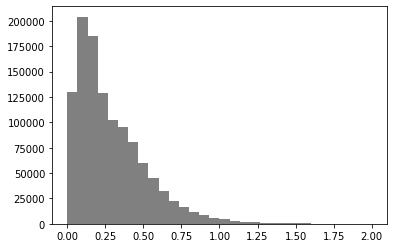

In [37]:
ax = plt.hist(df['Trip Seconds']/3600, 30, range=[0, 2], facecolor='gray', align='mid')

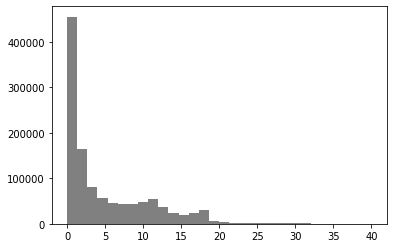

In [80]:
ax = plt.hist(df['Trip Miles'], 30, range=[0, 40], facecolor='gray', align='mid')

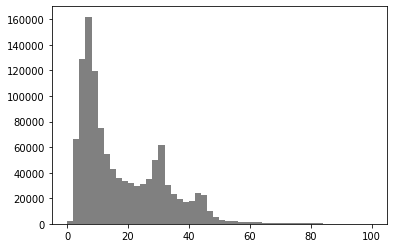

In [614]:
ax = plt.hist(df['Fare'], 50, range=[0, 100], facecolor='gray', align='mid')

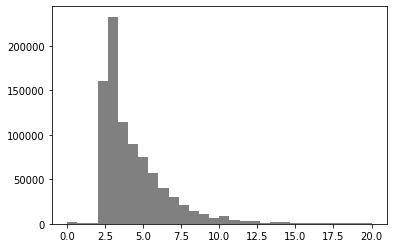

In [339]:
ax = plt.hist(df['unit_fare'], 30, range=[0, 20], facecolor='gray', align='mid')

In [25]:
df['Payment Type'].value_counts() / len(df)

Cash           0.427761
Credit Card    0.244651
Prcard         0.154959
Unknown        0.129830
Mobile         0.041777
Dispute        0.000710
No Charge      0.000308
Prepaid        0.000003
Name: Payment Type, dtype: float64

In [26]:
df['Company'].value_counts() / len(df)

Flash Cab                               0.329050
Taxi Affiliation Services               0.322192
Medallion Leasin                        0.060411
Taxicab Insurance Agency, LLC           0.051041
Sun Taxi                                0.040968
City Service                            0.036495
Blue Ribbon Taxi Association Inc.       0.027498
Top Cab Affiliation                     0.025992
Star North Management LLC               0.025526
Globe Taxi                              0.020113
U Taxicab                               0.016749
Chicago Independents                    0.015097
Patriot Taxi Dba Peace Taxi Associat    0.008828
24 Seven Taxi                           0.003707
Setare Inc                              0.003287
Chicago Taxicab                         0.002820
Choice Taxi Association                 0.001802
312 Medallion Management Corp           0.001741
KOAM Taxi Association                   0.001518
3591 - 63480 Chuks Cab                  0.001263
3556 - 36214 RC Andr

# Investigation on pickup census

In [509]:
# calculate median unit_fare by census
df_census_unit_fare_pickup = df.groupby('pick_up_census')['unit_fare'].median()  # use median to minimise the impacts of the extreme cases
df_census_unit_fare_pickup = df_census_unit_fare_pickup.to_frame(name="unit_fare")

# calculate trip counts and percentage by census
df_census_count_pickup = df.groupby(['pick_up_census']).size()
df_census_count_pickup = df_census_count_pickup.to_frame(name="count")
df_census_count_pickup['percentage'] = ["{0:.2f}%".format(val * 100) for val in df_census_count_pickup['count'] / len(df)]  
df_census_info_pickup = pd.merge(df_census_count_pickup, df_census_unit_fare_pickup, how='inner', on='pick_up_census')
df_census_info_pickup['census_tract_name'] = df_census_info_pickup.index

# merge with census polygon, remove census with trips less then 100
census_tracts = census_tracts.rename(columns = {'name10': 'census_tract_name'}, inplace = False)
census_tracts = census_tracts.astype({'census_tract_name': 'float64'})
df_census_pickup = pd.merge(census_tracts, df_census_info_pickup, how='inner', on='census_tract_name')
df_census_pickup_major = df_census_pickup[df_census_pickup['count'] > 100] 

In [492]:
df_census_pickup_major = df_census_pickup_major.sort_values('count', ascending=False)
df_census_pickup_major.head()

,census_tract_name,commarea,geometry,count,percentage,unit_fare
168,810.0,8,"MULTIPOLYGON (((-87.62980 41.89751, -87.62978 ...",192761,16.84%,4.729730
326,9800.0,76,"MULTIPOLYGON (((-87.92063 42.00453, -87.92056 ...",112081,9.79%,2.570423
52,8329.0,28,"MULTIPOLYGON (((-87.66656 41.87285, -87.66656 ...",85667,7.48%,4.090909
195,3204.0,32,"MULTIPOLYGON (((-87.61644 41.88233, -87.60925 ...",81045,7.08%,4.400000
340,622.0,6,"MULTIPOLYGON (((-87.65908 41.94395, -87.65909 ...",50678,4.43%,3.939394


In [493]:
map_chicago_cencus_pickup =KeplerGl(height = 800)
map_chicago_cencus_pickup.add_data(data = df_census_pickup_major, name = 'Pickup Census Tracts')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [599]:
map_chicago_cencus_pickup.save_to_html(file_name='map_chicago_cencus_pickup.html')

Map saved to map_chicago_cencus_pickup.html!


In [615]:
map_chicago_cencus_pickup

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [], 'interactionConfig': {'…

# Investigation on dropoff census

In [497]:
# calculate median unit_fare by census
df_census_unit_fare_dropoff = df.groupby('drop_off_census')['unit_fare'].median()  # use median to minimise the impacts of the extreme cases
df_census_unit_fare_dropoff = df_census_unit_fare_dropoff.to_frame(name="unit_fare")

# calculate trip counts and percentage by census
df_census_count_dropoff = df.groupby(['drop_off_census']).size()
df_census_count_dropoff = df_census_count_dropoff.to_frame(name="count")
df_census_count_dropoff['percentage'] = ["{0:.2f}%".format(val * 100) for val in df_census_count_dropoff['count'] / len(df)]  
df_census_info_dropoff = pd.merge(df_census_count_dropoff, df_census_unit_fare_dropoff, how='inner', on='drop_off_census')
df_census_info_dropoff['census_tract_name'] = df_census_info_dropoff.index

# merge with census polygon, remove census with trips less then 100
df_census_dropoff = pd.merge(census_tracts, df_census_info_dropoff, how='inner', on='census_tract_name')
df_census_major_dropoff = df_census_dropoff[df_census_dropoff['count'] > 100] 

In [498]:
df_census_major_dropoff = df_census_major_dropoff.sort_values('count', ascending=False)
df_census_major_dropoff.head()

,census_tract_name,commarea,geometry,count,percentage,unit_fare
187,810.0,8,"MULTIPOLYGON (((-87.62980 41.89751, -87.62978 ...",173575,15.16%,4.969880
56,8329.0,28,"MULTIPOLYGON (((-87.66656 41.87285, -87.66656 ...",79670,6.96%,4.094828
219,3204.0,32,"MULTIPOLYGON (((-87.61644 41.88233, -87.60925 ...",65560,5.73%,4.736842
393,622.0,6,"MULTIPOLYGON (((-87.65908 41.94395, -87.65909 ...",61430,5.37%,3.502415
414,711.0,7,"MULTIPOLYGON (((-87.65276 41.91811, -87.65276 ...",46547,4.07%,3.816794


In [500]:
map_chicago_cencus_dropoff = KeplerGl(height = 800)
map_chicago_cencus_dropoff.add_data(data = df_census_major_dropoff, name = 'Dopoff Census Tracts')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [600]:
map_chicago_cencus_dropoff.save_to_html(file_name='map_chicago_cencus_dropoff.html')

Map saved to map_chicago_cencus_dropoff.html!


In [616]:
map_chicago_cencus_dropoff

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '54yhd0g', 'type': …

# Investigation on Time of the Day

In [144]:
# calculate median unit_fare by hour
df_hour_unit_fare = df.groupby('hour')['unit_fare'].median()  # use median to minimise the impacts of the extreme cases
df_hour_unit_fare = df_hour_unit_fare.to_frame(name="unit_fare")

# calculate trip counts and percentage by hour
df_hour_count = df.groupby(['hour']).size()
df_hour_count = df_hour_count.to_frame(name="count")
df_hour_count['percentage'] = ["{0:.2f}%".format(val * 100) for val in df_hour_count['count'] / len(df)]  
df_hour_info = pd.merge(df_hour_count, df_hour_unit_fare, how='inner', on='hour')
df_hour_info['hour'] = df_hour_info.index

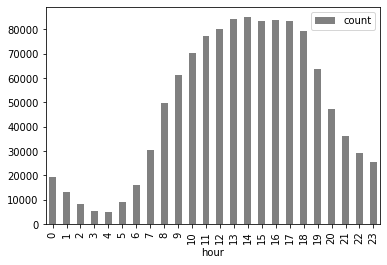

In [162]:
ax = df_hour_info.plot(x='hour', y=["count"], kind="bar", facecolor='gray')

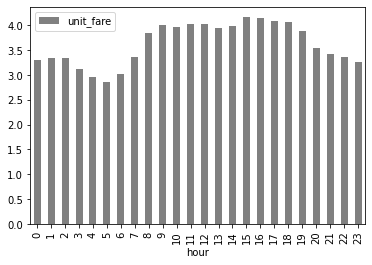

In [163]:
ax = df_hour_info.plot(x='hour', y=["unit_fare"], kind="bar", facecolor='gray')

# Investigation on Day of the Week

In [181]:
df_weekend = df[df['is_weekday'] == False]

In [182]:
len(df_weekend)

264986

In [185]:
# calculate median unit_fare by hour
df_hour_unit_fare = df_weekend.groupby('hour')['unit_fare'].median()  # use median to minimise the impacts of the extreme cases
df_hour_unit_fare = df_hour_unit_fare.to_frame(name="unit_fare")

# calculate trip counts and percentage by hour
df_hour_count = df_weekend.groupby(['hour']).size()
df_hour_count = df_hour_count.to_frame(name="count")
df_hour_count['percentage'] = ["{0:.2f}%".format(val * 100) for val in df_hour_count['count'] / len(df_weekend)]  
df_hour_info = pd.merge(df_hour_count, df_hour_unit_fare, how='inner', on='hour')
df_hour_info['hour'] = df_hour_info.index

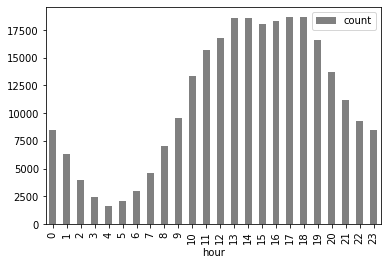

In [186]:
ax = df_hour_info.plot(x='hour', y=["count"], kind="bar", facecolor='gray')

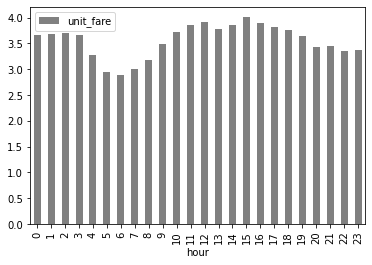

In [187]:
ax = df_hour_info.plot(x='hour', y=["unit_fare"], kind="bar", facecolor='gray')

# Price Prediction

fly_distance (numerical)

pickup_census_tract (categorical)

dropoff_census_tract (categorical)

hour (categorical)

day (boolean)


In [554]:
import lightgbm as lgbm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [593]:
df = df[df['Trip Miles'] <= 50]
df = df[df.Fare <= 150]
df = df[df.Fare > 0]
df_model = df[['Fare', 'is_weekday', 'hour', 'pick_up_census', 'drop_off_census', 'fly_distance']]
df_model = df_model.dropna(axis=0)
df_model = df_model.reset_index(drop=True)

In [594]:
y = df_model.Fare.values
x = df_model.drop(['Fare'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=815)

In [595]:
cat_features = [1,2,3]
best_params = {
    'subsample': 0.75,
    'reg_alpha': 61.0,
    'reg_lambda': 0.24,
    'learning_rate': 0.33, 
    'num_leaves': 80,  
}
# lgbm_best = lgbm.LGBMRegressor(**best_params)
lgbm_best.fit(x, y)
lgbm_best.fit(x, y, categorical_feature=cat_features)

/Users/hongde.liang/opt/anaconda3/envs/py36hd/lib/python3.6/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMRegressor(learning_rate=0.33, num_leaves=80, reg_alpha=61.0,
              reg_lambda=0.24, subsample=0.75)

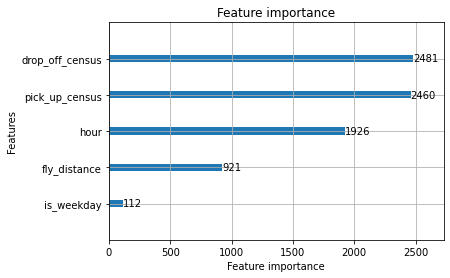

In [596]:
ax = lgbm.plot_importance(lgbm_best)

In [597]:
score = lgbm_best.score(x, y)
print(score)

0.8047324956742443


In [598]:
## Test for lgbm
y_pred = lgbm_best.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('mae: {:.3f}, mape: {:.3f}'.format(mae, mape))

mae: 3.275, mape: 0.334


In [587]:
%%html
<style>
table {align:left;display:block}
</style>

| Exp | MAE | MAPE | SCORE |
| :-- | :-- | :-- | :-- |
| native setting | 3.46 | 0.35 | 0.79 |
| native setting categorical census | 3.36 | 0.34 | 0.79 |
| customised setting 1 | 3.39| 0.22 | 0.73 |
| customised setting 1  categorical census | 3.39 | 0.22 | 0.73 |
| customised setting 2 | 3.33 | 0.34 | 0.80 |
| customised setting 2 categorical census | 3.28 | 0.33 | 0.80 |
| customised setting 2 categorical census hour | 3.27 | 0.33 | 0.80 |

In [433]:
pd.Series(abs(y_pred - y_test)/y_test).describe()

count    2.283550e+05
mean     3.383122e-01
std      4.791330e+00
min      2.730379e-07
25%      5.380452e-02
50%      1.438308e-01
75%      3.446424e-01
max      1.123063e+03
dtype: float64

In [378]:
pd.Series(abs(y_pred - y_test)/y_test).describe()

count    2.283550e+05
mean     2.231528e-01
std      2.570876e+00
min      8.501113e-07
25%      4.794024e-02
50%      1.243516e-01
75%      2.666673e-01
max      5.434750e+02
dtype: float64

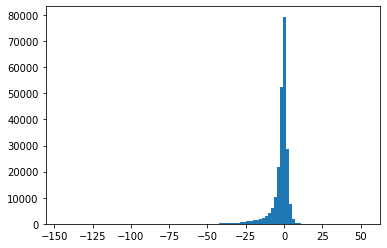

In [421]:
ax = plt.hist(y_pred - y_test, bins = 100)